<a href="https://colab.research.google.com/github/lucaskydelima/Optimization-with-Python-Pyomo/blob/main/S3Example2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pyomo
! apt-get install -y -qq glpk-utils

In [21]:
import os
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

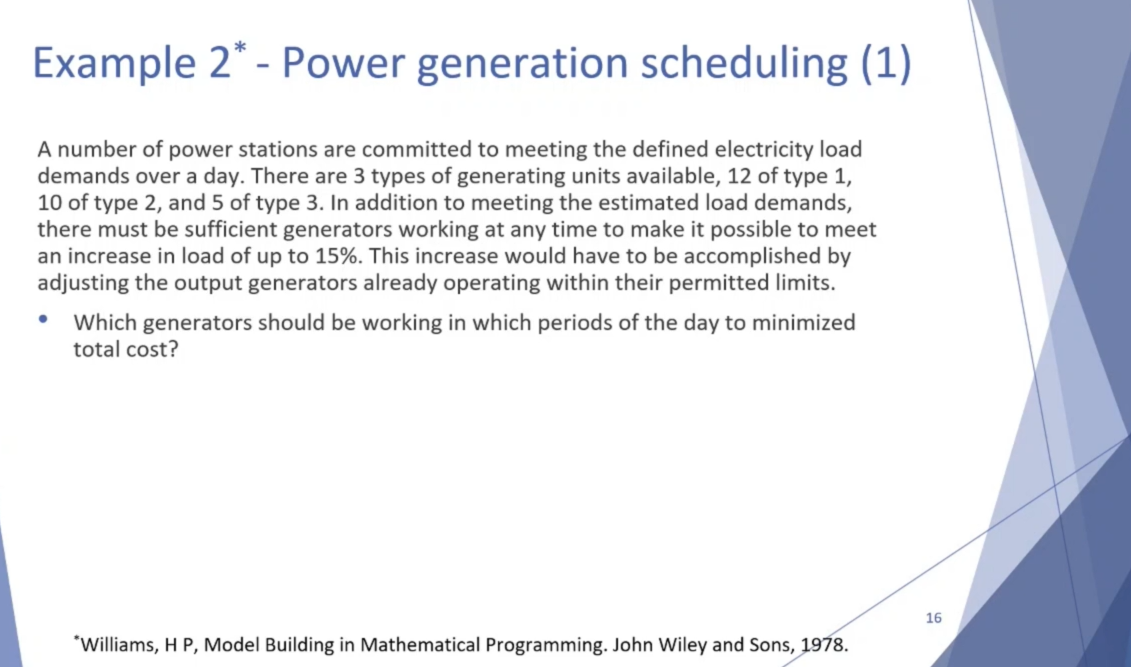

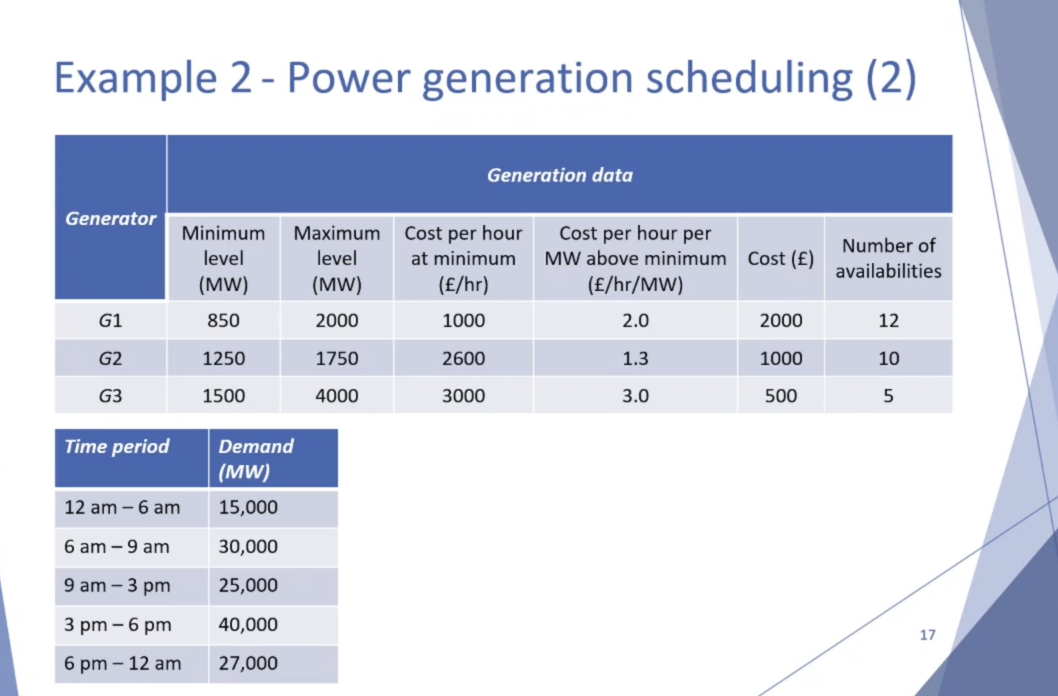

In [29]:
# Defining the model
model = pyo.ConcreteModel()

# Sets
model.t = pyo.Set(initialize=('T1', 'T2', 'T3', 'T4', 'T5'))
model.g = pyo.Set(initialize=('G1', 'G2', 'G3'))

# Decision Variables
model.x = pyo.Var(model.g, model.t, domain=pyo.NonNegativeReals)
model.s = pyo.Var(model.g, model.t, domain=pyo.NonNegativeIntegers)


# Params
model.delta = pyo.Param(model.t, initialize={'T1':15000, 'T2':30000, 'T3':25000, 'T4':40000, 'T5':27000})
model.theta = pyo.Param(model.t, initialize={'T1':6, 'T2':3, 'T3':6, 'T4':3, 'T5':6})

model.alpha = pyo.Param(model.g, initialize={'G1':{'min_pow':850, 'max_pow':2000, 'min_cost':1000, 'inc_cost':2.0, 'start':2000, 'gen_lim':12},
                                             'G2':{'min_pow':1250, 'max_pow':1750, 'min_cost':2600, 'inc_cost':1.3, 'start':1000, 'gen_lim':10},
                                             'G3':{'min_pow':1500, 'max_pow':4000, 'min_cost':3000, 'inc_cost':3.0, 'start':500, 'gen_lim':5}
                                             });
def bounds_for_n(model,g,t):
  return (0, model.alpha[g]['gen_lim'])
model.n = pyo.Var(model.g, model.t, domain=pyo.NonNegativeIntegers, bounds=bounds_for_n)

def epsilon_rule(model,g,t):
  return model.theta[t]*model.alpha[g]['min_cost']
model.epsilon = pyo.Param(model.g, model.t, initialize=epsilon_rule)

def phi_rule(mode,g,t):
  return model.theta[t]*model.alpha[g]['inc_cost']
model.phi = pyo.Param(model.g, model.t, initialize=phi_rule)

# Defining a new set tnew as a parameter to help with sequencing of the time periods 
model.tnew = pyo.Param(model.t, initialize={'T1':5, 'T2':1, 'T3':2, 'T4':3, 'T5':4})

# Objective Function
def Objective_rule(model):
  term1 = sum(sum(model.epsilon[g,t]*model.n[g,t] for g in model.g) for t in model.t);
  term2 = sum(sum(model.alpha[g]['start']*model.s[g,t] for g in model.g) for t in model.t);
  term3 = sum(sum(model.phi[g,t]*(model.x[g,t]-model.alpha[g]['min_pow']*model.n[g,t]) for g in model.g) for t in model.t);
  return term1 + term2 + term3
model.obj = pyo.Objective(rule=Objective_rule, sense=pyo.minimize)

# Constraints
def Constraint_1(model,t):
  return sum(model.x[g,t] for g in model.g) >= model.delta[t]  
model.const1 = pyo.Constraint(model.t, rule=Constraint_1, doc='Power demand satisfaction')

def Constraint_2(model,t):
  return sum(model.alpha[g]['max_pow']*model.n[g,t] for g in model.g) >= 1.15*model.delta[t]
model.const2 = pyo.Constraint(model.t, rule=Constraint_2, doc='Spinning reserve requirement')

def Constraint_3(model,g,t):
  s = model.tnew[t]
  ss = model.t.at(s)
  return model.s[g,t] >= model.n[g,t] - model.n[g, ss]

model.const3 = pyo.Constraint(model.g, model.t, rule=Constraint_3, doc='Start-up definition')

def Constraint_4(model,g,t):
  return model.x[g,t] >= model.alpha[g]['min_pow']*model.n[g,t]
model.const4 = pyo.Constraint(model.g, model.t, rule=Constraint_4, doc='Minimum generation levels')

def Constraint_5(model,g,t):
  return model.x[g,t] <= model.alpha[g]['max_pow']*model.n[g,t]
model.const5 = pyo.Constraint(model.g, model.t, rule=Constraint_5, doc='Maximum generation levels')

# Solve
os.environ['NEOS_EMAIL'] = 'lucaskydelima@gmail.com'
results = pyo.SolverManagerFactory('neos').solve(model, opt='cplex')
#results = pyo.SolverFactory('glpk', executable='/usr/bin/glp sol').solve(model)

results.write()
print("\nRESULTS:");
print("\nTotal cost of power generation = ",model.obj());
for g in model.g:
  for t in model.t:
    print("\nOutput of generator",g,"during time period",t," = ",model.x[g,t]());
print("\n");
for g in model.g:
  for t in model.t:
    print("\nNumber of generators of type",g,"in use during time period",t," = ",model.n[g,t]());
print("\n");
for g in model.g:
  for t in model.t:
    print("\nNumber of generators of type",g,"started up during time period",t," = ",model.s[g,t]());


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 55
  Number of variables: 45
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: CPLEX 20.1.0.0\x3a optimal integer solution; objective 988540.0000000001; 31 MIP simplex iterations; 0 branch-and-bound nodes
  Termination condition: optimal
  Id: 2
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: